# Topic Modeling


## Additional Resources and References

Code and Examples

* Sample code for [topic extraction in Scikit-Learn](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html).
* Documentation for LDA using [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) documentation.
* Examples for using [Top2Vec on ReadtheDocs](https://top2vec.readthedocs.io/en/latest/).
* Youtube Video on Top2Vec by the [Python Tutorials for Digital Humanities](https://www.youtube.com/watch?v=bEaxKSQ4Av8) channel.

Papers

* ["Latent Dirichlet Allocation"](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) by Blei, Ng, and Jordan (2003).
* ["Top2Vec: Distributed Representations of Topics"](https://arxiv.org/abs/2008.09470) by Angelov (2020).

In [ ]:
# Import standard data and visualization libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import the LDA items from scikit-learn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import *

# Import the Top2Vec
# This also requires installation on Colaboratory, as it's not pre-installed (😢)
#!pip install top2vec[sentence_encoders]
#from top2vec import Top2Vec

## Motivation

Let's say you have a corpus (a collection of text documents) that you suspect can be grouped in some way. Some examples:
* Customer reviews which are talking about some feature of your restaurant (the food, the service, the atmosphere, &c.)
* Tweets about Supreme Court rulings (agreeing with or disagreeing with the ruling, or perhaps groupable by which ruling they're discussing)
* Articles about COVID (death toll, new variants, the vaccine, misinformation)
* Descriptions of movies (different genres?)

But you have potentially thousands of documents. Actually labeling each would require you to both read *all* of them and also, while you're reading them, decide on what those labels are. Perhaps you change your mind part way through and decide to change them. It's too much work.

Is there a way to both group the documents *and* find a good list of labels at the same time? Yes. That's what topic modelling is.

Topic modelling is a class of **unsupervised clustering** algorithms. In this notebook, we'll be looking at two popular algorithms:

* **LDA (Latent Dirichlet Allocation)** Is a 20 year old, fairly simple algorithm. It's popular because it is well-established, if limited in utility. It models documents and topics as "bags of words," and also allows documents to fit into multiple topics.
* **Top2Vec** is a 3 year old, very sophisticated algorithm. It models not only the words in the documents, but also takes into account their relationships to each other and to similar words by modelling them as vectors in a high-dimensional space.

## Sample Dataset

This dataset is hotel reviews from the site TripAdvisor. One imagines that there are different things to say about each hotel: one might be the cleanliness of the rooms, the helpfulness of the staff, its location, or its bar. But we don't have that information in the dataset, only the rating from 1-5.

Let's use topic modelling to see what kinds of things people are saying about hotels, and whether there's a way to organically group them. We could also imagine repeating this analysis for ratings of 1-2 and ratings of 4-5: what do people say about good hotels? About bad hotels?

In [ ]:
dataset = pd.read_csv("https://raw.githubusercontent.com/Greg-Hallenbeck/class-datasets/main/datasets/netflix.csv")
#dataset = pd.read_csv("https://raw.githubusercontent.com/Greg-Hallenbeck/class-datasets/main/datasets/tripadvisor_hotel_reviews.csv")

dataset.head(5)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,8.3,795222.0,27.612,8.2
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,8.2,530877.0,18.216,7.8
3,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['comedy'],['GB'],NaN,tt0079470,8.0,392419.0,17.505,7.8
4,tm190788,The Exorcist,MOVIE,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,['horror'],['US'],NaN,tt0070047,8.1,391942.0,95.337,7.7


## Latent Dirichlet Allocation
LDA works like this:
* Each topic corresponds to some set of word counts. Perhaps "sandwich" is very common in topic 1, does not appear in topic 2, and is uncommon in topic 3. Keep in mind that we do not know what these topics are ahead of time.
* Each document is not one pure topic, but a mixture of all of them. A document might be 85% topic 1, 15% topic 2, and 0% topic 3. So we expect the word counts of that document to look like that combination of those topics.
* Sci-Kit Learn's fitting process figures out what the word counts for each topic and the topics for each document for us, such that the real observed word counts for each document are as close as possible to what you should have theoretically. It tries to minimize the "perplexity", which is a measure of how surprising it is to find any particular word in a document.

## Worked Example with LDA



In [ ]:
# Create a pipeline for reducing the data

# max_features = The size of the vocabulary. Anything beyond the top X words will be ignored.
# n_components = The number of topics to fit.

#Max features means look at the top X number of words used

text_pipeline = Pipeline([
     ('tokenize', CountVectorizer(max_features=1000, stop_words="english")), #does the counting
     ('tfidf', TfidfTransformer(use_idf=True)), #caluclates the tfidf
     ('lda', LatentDirichletAllocation(n_components=20)) #does the LDA model
    ])

In [ ]:
# If you change your dataset, you'll need to tell it the name of the column with the text to analyze.
# In the example dataset, that column is called "Review"

# The starting point of LDA is random, so you get different results each time.
# To keep everything consistent across the class, let's use Valjean's constant
np.random.seed(24601)

text_pipeline.fit_transform(dataset["description"]);

What do we get from this pipeline? Let's take a look.

First, here are the weights for different *topics*:

In [ ]:
word_list = text_pipeline["tokenize"].get_feature_names_out()
topic_num = 4 #can change this number to see different topics
num_words = 10

df = pd.DataFrame({"words": word_list, "weights": text_pipeline["lda"].components_[topic_num]})

df.sort_values("weights", ascending=False).head(num_words)

,words,weights
647,party,13.849224
198,crisis,10.610635
316,family,10.598211
926,turned,9.946678
528,life,9.739515
592,monsters,9.125819
841,step,8.991540
565,master,8.801351
241,discover,8.631525
417,hero,8.344737


This tells us how a particular document fits into each of the topics:

In [ ]:
text_pipeline.transform(["Comedy Horror."])
#text_pipeline.transform(["I loved to read by the beach and eat at the fancy restaurant."])

array([[0.02093638, 0.02093638, 0.02093638, 0.02093638, 0.02093639,
        0.02093638, 0.02093638, 0.60220872, 0.02093638, 0.02093638,
        0.02093638, 0.02093638, 0.02093638, 0.02093638, 0.02093638,
        0.02093638, 0.02093638, 0.02093638, 0.02093638, 0.02093638]])

We can also get the topics for every document in our dataset:

In [ ]:
topics = text_pipeline.transform(dataset["description"])

In [ ]:
index = 100

dataset["genres"][index], topics[index]

("['drama', 'thriller', 'action']",
 array([0.01386959, 0.01386959, 0.01386959, 0.01386959, 0.01386959,
        0.01386959, 0.01386959, 0.01386959, 0.01386959, 0.01386959,
        0.01386959, 0.01386959, 0.01386959, 0.01386959, 0.01386959,
        0.40831251, 0.01386959, 0.01386959, 0.34203495, 0.01386959]))

And also visualize the topics (this is probably the most useful part)

In [ ]:
# This code was taken from the Scikit-Learn demo posted above

def plot_top_words(pipeline, n_top_words=10, grid_shape=[4,5]):

    feature_names = pipeline["tokenize"].get_feature_names_out()
    model = pipeline["lda"]
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        #fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

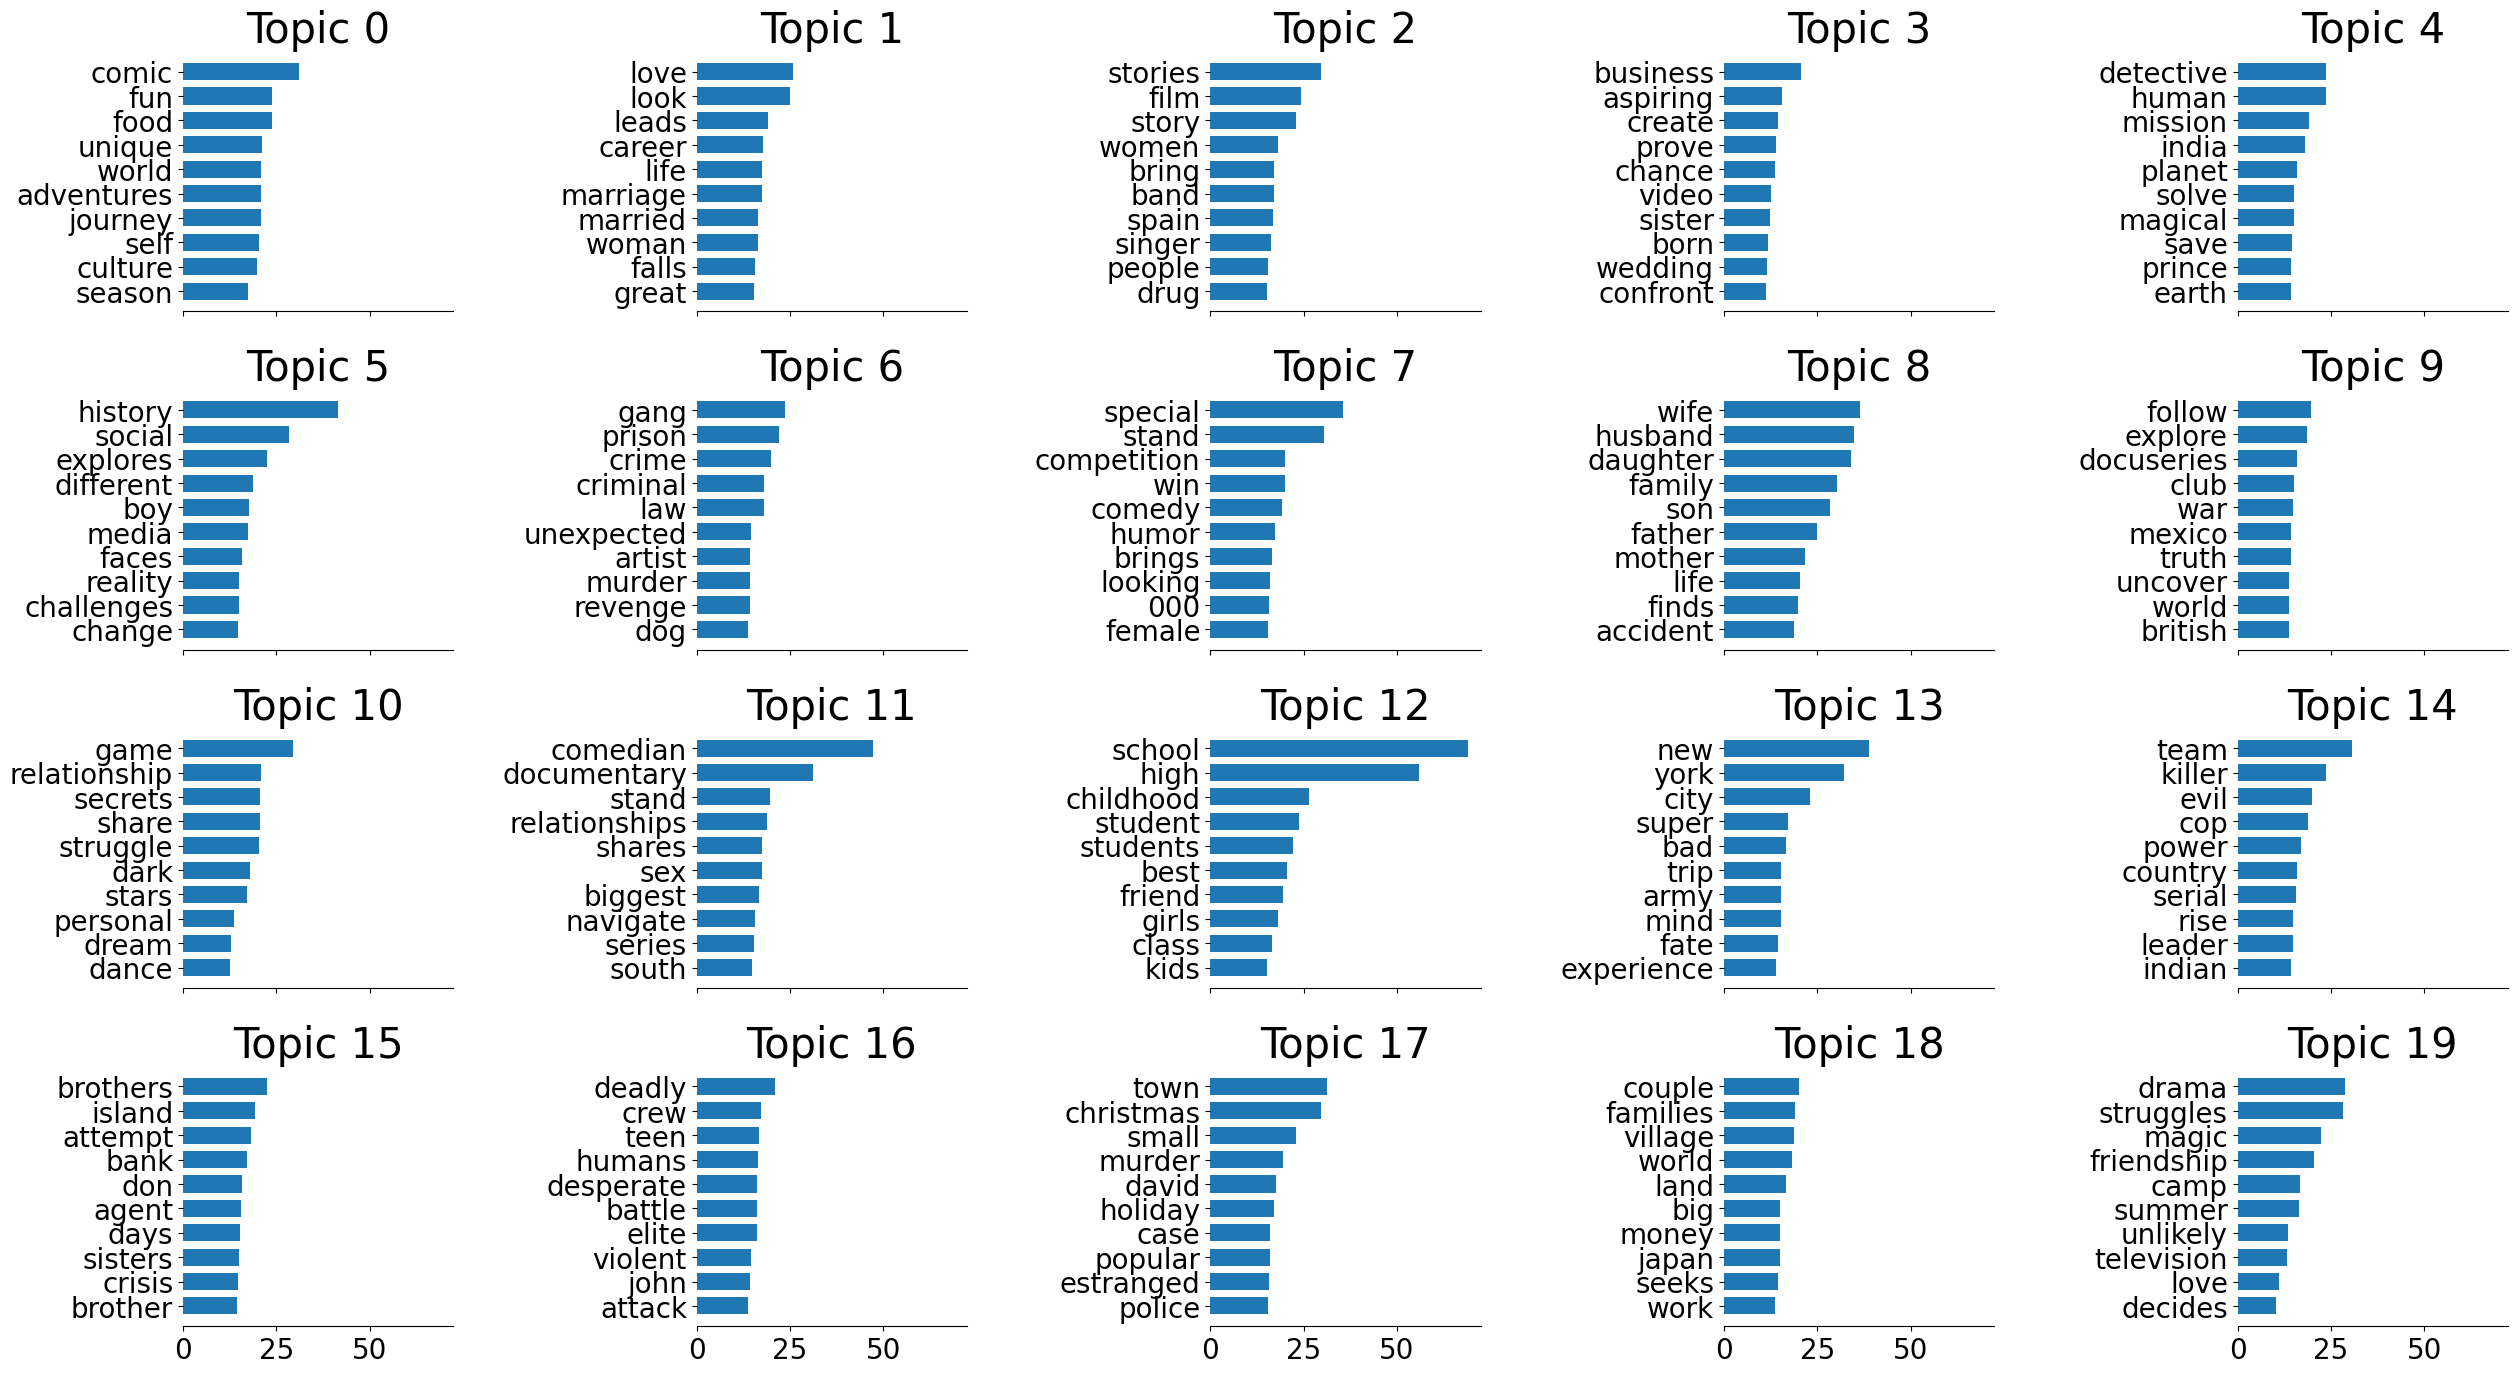

In [ ]:
#Plots the top 10 words
# Showing the topics in a 4x5 grid (keep this below your number of topics)
plot_top_words(text_pipeline, 10, [4,5])

## In-Lecture Exercise

Change the dataset to the Netflix dataset (it's already commented out above). What do you see for genres in the descriptions?